In [13]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.integrate import quad
from scipy import interpolate
from chain_analysis import contour_plot, gelman_rubin
import time
import pymultinest
from collections import OrderedDict
%matplotlib nbagg
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
plt.rcParams['nbagg.transparent'] = False
plt.rcParams['figure.facecolor'] = 'w'

In [4]:
c=2.99792e5
mu_err = 0.2
fiducial_cos = np.array([0.31, -1, 67.74])

In [5]:
def func(z, om_m, w):
    """Function to integrate in computing d_L"""
    return (om_m*(1+z)**3.0+(1-om_m)*(1+z)**(3*(w+1)))**(-0.5)


def dist(z, om_m, w, H0):
    """Compute distance modulus for an array of redshifts"""
    mu=[]
    for k in range(len(z)):
        y, yerr = quad(func,0.0,z[k],args=(om_m, w))
        d = c*(1.0+z[k])/H0*y
        
        mu.append(5.0*np.log10(d) + 25.0)
    return np.array(mu)

In [107]:
def make_data(N, mu_err=0.2, mu_err_actual=0.2, zmin=0.015, zmax=1, om_m=0.31, w=-1, H0=67.74):
    """Little function to generate dataset"""
    z = np.random.uniform(zmin, zmax, N)
    mu = dist(z, om_m, w, H0)
    mu += np.random.randn(N)*mu_err_actual
    
    return np.column_stack((z, mu, [mu_err]*len(z)))

In [7]:
def corrupt_redshifts(data, delta_z, inds=[]):
    """Corrupts the redshifts of existing data
    z_err = delta_z * (1+z)"""
    z = data[:,0].copy()
    if len(inds) == 0:
        inds = np.arange(len(z))
    z_err = np.zeros(len(z))
    z_err[inds] = delta_z * (1+z[inds])
    
    z += np.random.randn(len(z))*z_err
    return np.column_stack((z, data[:,1], data[:,2]))

In [88]:
class FitData:
    """
    Encapsulated class for fitting some HI profile data
    """
    def __init__(self, dat, model='std', z_err=[], inds=[], bounds=[]):       

        if len(bounds) == 0:
            self.bounds = OrderedDict([
                    ('Om', [0, 1]),
                    ('w', [-6, 4]),
                    ('H0', [10, 200]),
                    ('z', [0, 1.4])
                ])
        else:
            self.bounds = bounds

        self.dat = dat
        self.z_err = z_err
        self.inds = inds
        
        if model == 'std':
            self.lnprob = self.lnprob_std
            self.ndim = 3
        else:
            self.lnprob = self.lnprob_zbeams
            if len(inds) == 0:
                self.ndim = 3 + len(dat)
            else:
                self.ndim = 3 + len(inds)
        

    def lnprob_std(self, cube, ndim, nparams):
        """
        ln(posterior probability) function. Combines likelihood and prior.
        Parameters
        ----------
        p : list or np.array
            Array of parameters
        dat : np.array
            Data in the form first column redshift, second column mu    

        Returns
        -------
        log(posterior) : float

        """
        
        dat = self.dat 
        p = cube
        

        om_m, w,  H0 = p[:3]
        z_spl = np.linspace(min(dat[:, 0]), max(dat[:, 0]),50)
        y_spl = dist(z_spl, om_m, w, H0)
        spline = interpolate.splrep(z_spl, y_spl)

        mu_fit = interpolate.splev(dat[:,0], spline)

        chi2 = np.sum(((dat[:,1]-mu_fit)/dat[:,2])**2)
        return -0.5*chi2

    def lnprob_zbeams(self, cube, ndim, nparams):
        """
        ln(posterior probability) function. Combines likelihood and prior.
        Parameters
        ----------
        p : list or np.array
            Array of parameters
        dat : np.array
            Data in the form first column redshift, second column mu
        z_err : np.array
            Array of redshift errors (assumed to be gaussian)
        inds : list, optional
            Pass a list of indices if you don't want to vary the redshift of every object

        Returns
        -------
        log(posterior) : float

        """
        dat = self.dat 
        z_err = self.z_err 
        inds = self.inds
        p = np.zeros(ndim)
        for i in range(ndim):
            p[i] = cube[i]
        
        om_m, w,  H0 = p[:3]

        if len(inds)==0:
            Z = p[3:]
            inds = np.arange(len(dat[:,0]))
        else:
            Z = dat[:,0].copy()
            Z[inds] = p[3:]


        z_spl = np.linspace(min(Z), max(Z),50)
        y_spl = dist(z_spl, om_m, w, H0)
        spline = interpolate.splrep(z_spl, y_spl)

        mu_fit = interpolate.splev(Z, spline)

        chi2_mu = np.sum(((dat[:,1]-mu_fit)/dat[:,2])**2)
        chi2_z = np.sum(((dat[inds,0]-Z[inds])/z_err[inds])**2)

        #print(chi2_mu, chi2_z)
    #     norm_mu = np.sum(np.log(1/np.sqrt(2*np.pi*dat[:,2]**2)))
    #     norm_z = np.sum(np.log(1/np.sqrt(2*np.pi*z_err[inds]**2)))


        #return norm_mu + norm_z -0.5*(chi2_mu + chi2_z)
        return -0.5*(chi2_mu + chi2_z)
        

    def prior(self, cube, ndim, nparams):
        """
        Prior for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        array
            Transformed parameter cube

        """
        keys = list(self.bounds.keys())
        for i in range(3):
            lower = self.bounds[keys[i]][0]
            upper = self.bounds[keys[i]][1]
            cube[i] = cube[i]*(upper-lower)+lower
        if ndim>3:
            for i in range(3, ndim):
                lower = self.bounds['z'][0]
                upper = self.bounds['z'][1]
                cube[i] = cube[i]*(upper-lower)+lower
        return cube



    def fit(self, chain_name='chain', n_live_points=500, multimodal=True):

        t1 = time.time()
        
        pymultinest.run(self.lnprob, self.prior, self.ndim, importance_nested_sampling = True, init_MPI = False,
                        resume = False, verbose = False, sampling_efficiency = 'parameter', 
                        n_live_points = n_live_points, outputfiles_basename = chain_name, multimodal = multimodal)
        print('Time taken', time.time()-t1)

In [108]:
nz = 5
delt_z = 0.04
dat = make_data(998, mu_err=0.2, mu_err_actual=0)

z_err = delt_z*(1+dat[:,0])
inds = np.random.choice(np.arange(len(dat)), nz, replace=False)
print(inds)

[963 227 975 914 617]


In [98]:
new_dat = corrupt_redshifts(dat, delt_z, inds=inds) # What the data would be if we corrupted some redshifts

In [109]:
fd = FitData(dat, model='std')
fd.fit(chain_name='std-')

Time taken 25.723437070846558


Time taken 23.639740467071533


In [79]:
start_point = np.hstack((fiducial_cos, new_dat[inds,0]))
fd.lnprob_zbeams(start_point, 3+len(inds), 3+len(inds))

[ 0.04739039  0.60048853  0.99313597  0.61036761  0.69660987]


-0.26483145448118284

In [110]:
fd = FitData(dat, model='zbeams', z_err=z_err, inds=inds)
fd.fit(chain_name='zbeams-')

Time taken 184.10057282447815


In [111]:
chain_std = np.loadtxt('std-post_equal_weights.dat')
chain_zbeams = np.loadtxt('zbeams-post_equal_weights.dat')

<IPython.core.display.Javascript object>


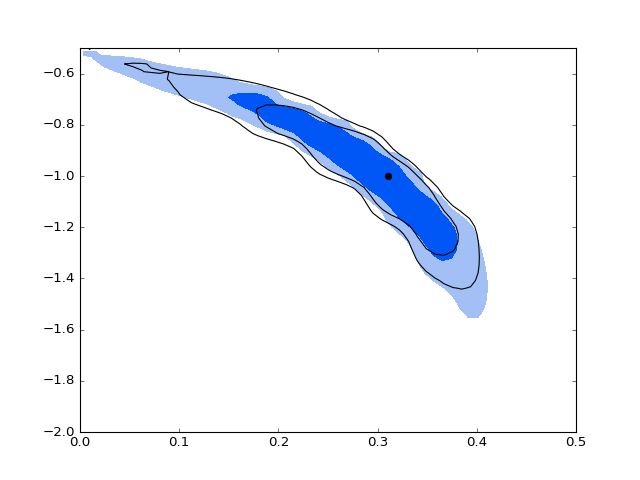

(-2, -0.5)

In [112]:
plt.figure()
contour_plot.contour(chain_std, [0,1], smooth=4e3, line=True, col='k')
contour_plot.contour(chain_zbeams, [0,1], smooth=4e3)
plt.plot(fiducial_cos[0], fiducial_cos[1], 'ok')
plt.xlim([0, 0.5])
plt.ylim([-2, -0.5])

In [93]:
dat[inds,0]

array([ 0.04739039,  0.60048853,  0.99313597,  0.61036761,  0.69660987])

<IPython.core.display.Javascript object>


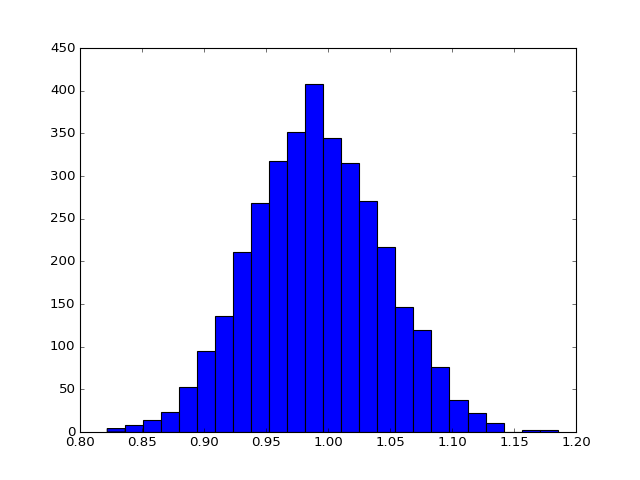

(array([   4.,    8.,   14.,   23.,   53.,   95.,  136.,  211.,  268.,
         318.,  351.,  408.,  345.,  315.,  271.,  217.,  146.,  119.,
          76.,   38.,   22.,   10.,    0.,    2.,    2.]),
 array([ 0.8219648 ,  0.83649202,  0.85101924,  0.86554647,  0.88007369,
         0.89460091,  0.90912813,  0.92365535,  0.93818258,  0.9527098 ,
         0.96723702,  0.98176424,  0.99629146,  1.01081869,  1.02534591,
         1.03987313,  1.05440035,  1.06892757,  1.0834548 ,  1.09798202,
         1.11250924,  1.12703646,  1.14156368,  1.15609091,  1.17061813,
         1.18514535]),
 <a list of 25 Patch objects>)

In [95]:
plt.figure()
plt.hist(chain_zbeams[:,5], 25)